## Process shadow tomography

Process shadows have been introduced and discussed in various works [Kunjummen et al, Phys. Rev. A 107, 042403 (2023)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042403), 
  [Levy,et al Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029). 
  
  To reduce statistical errors, we will also use Common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352)
  
We are interested here in estimating physical properties associated with a quantum process $\mathcal{E}:\rho_i\to \rho_f=\mathcal{E}(\rho_i)$. In this tutorial, we will represent $\mathcal{E}$ as a Choi Matrix $\Lambda$ using the isomorphism
$$\Lambda = \sum_{\xi',\xi}\ket{\xi'}\bra{\xi}\otimes \mathcal{E}(\ket{\xi'}\bra{\xi})$$
 and build process shadows $\hat{\Lambda}$ that satisfy $E[\hat \Lambda]=\Lambda$.

 Numerically, the Choi matrix can created by evolving the unnormalized density matrix
 $$\rho_0=[\sum_{\xi'}\ket{\xi'}^{\otimes 2}][\sum_{\xi}\bra{\xi}^{\otimes 2}]$$
 representing a Bell state between two copies on the $N$ qubit system. We then have $\Lambda= (1\otimes\mathcal{E})(\rho)$

 In this example, we will consider the Choi Matrix of an ideal quantum circuit $\mathcal{E}$, and the one $\mathcal{E}_0$ of a noisy quantum circuit.

In [1]:
using ProgressMeter
using ITensors
using RandomMeas

In [2]:
N = 2
depth = 2
ξ = siteinds("Qubit", N;addtags="output")
s = siteinds("Qubit", N;addtags="input")

#Create a Bell-State density matrix with an ancilla space to compute the choi Matrix
ρ0 = MPO(ξ)
for i in 1:N
    ρ0[i] = δ(s[i],ξ[i])*δ(s[i]',ξ[i]')
end

circuit    = random_circuit(ξ, depth)
Λ0 = apply(circuit,ρ0,apply_dag=true);

p  = 0.2*rand(N)
Λ = apply_depo_channel(Λ0,p);

In this tutorial we will be interested in measuring the process fidelity $\mathcal{F}=\frac{1}{4^N}\braket{\Lambda|\Lambda_0}$, where $\braket{.|.}$ is the inner product. Note: this expression holds because $\Lambda_0$ is a unitary channel, otherwise one would need to use a more complicated expression.

In [3]:
F = real(inner(Λ,Λ0)/4^N)
println(" -- Process Fidelity ", F)

 -- Process Fidelity 0.8270999155922544


Consider a random initial state $U_i^\dag\ket{0}^{\otimes N}$ and a measurement $s$ performed after a random rotation $U_f$, both $U_i$, $U_f$ being single qubit Haar random rotations, then the following process shadow can be constructed [Eq (B2) in  [Levy,et al Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029)] 

$$\hat{\Lambda}=2^N\mathcal{M}^{-1}([U_i^\dag\ket{0}^{\otimes N}\bra{0}U_i]^T) \otimes \mathcal{M}^{-1}(U_f^\dag\ket{s}^{\otimes N}\bra{s}U_f)$$ 

In order to reduce statistical errors, we also utilize the knowledge of the ideal process $\Lambda_0$ and use the concept of common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352) to buid process shadows as
$$\hat{\Lambda}_{\text{CRM}}=\hat{\Lambda}-\hat{\Lambda}_0+\Lambda_0$$

When $\Lambda\approx \Lambda_0$, such CRM shadows are much loss prone to statistical errors, while still being unbiased estimator of the unknown Choi matrix $\Lambda$.

In [4]:
nu = 1000
NM = 5000
states = ["Dn" for n in 1:N]
ψ  = MPS(ComplexF64,ξ,states)
ρ = outer(ψ',ψ)
data = zeros(Int,(NM,N))
Λs = ITensor(vcat(ξ,ξ',s,s'))
Fs = zeros(Float64,nu)

#construct the projector |0><0|, which will be useful to build the process shadow below
P0 = flatten([state(ξ_i,"Dn") for ξ_i in ξ])

Λs_CRM = ITensor(vcat(ξ,ξ',s,s'))
Fs_CRM = zeros(Float64,nu)

@showprogress dt=1 for r in 1:nu   
        ui = get_rotations(ξ,1) #Haar rotations for the initial state preparation
        uid = [swapinds(dag(ui[i]),ξ[i],ξ[i]') for i in 1:N] #We compute u_i^\dag

        uf = get_rotations(ξ,1) #Haar rotations in A
        ### Quantum Measurements
        ρu = apply(uid,ρ,apply_dag=true)
        ρe = apply(circuit,ρu,apply_dag=true)
        ρen = apply_depo_channel(ρe,p)

        #Build shadow for the initial state. Here we use Eq (B2) in using Eq (B2)
        ρi = get_shadow(P0,ξ,ui)
        replaceinds!(ρi,ξ',s) #Final transposition
        replaceinds!(ρi,ξ,s')

        #Build shadow for the final state
        data = get_RandomMeas(ρen,uf,NM)
        P = get_Born(data,ξ)
        ρf = get_shadow(P,ξ,uf)

        #Form process shadow
        Λt = 2^N*ρi*ρf
        Λs += Λt

        Fs[r] = real(inner(Λs,flatten(Λ0))/2^(2*N))/r
        
        ## CRM part ##
        P = get_Born(apply(uf,ρe,apply_dag=true)) #Simulate RM on the ideal channel
        ρf = get_shadow(P,ξ,uf)
        Λt_CRM = Λt-2^N*ρi*ρf+flatten(Λ0)
        Λs_CRM += Λt_CRM
        Fs_CRM[r] = real(inner(Λs_CRM,flatten(Λ0))/2^(2*N))/r
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


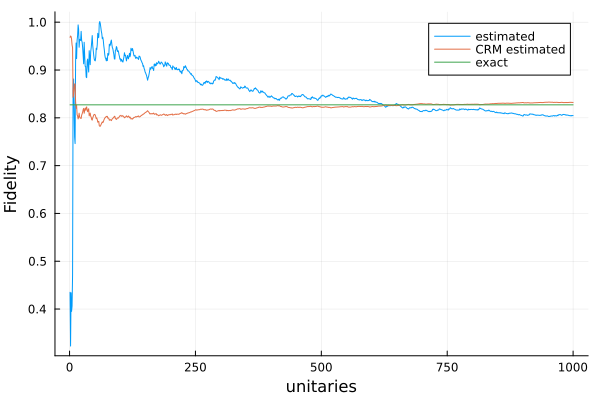

In [7]:
using Plots
plot(1:nu,Fs,label="estimated")
plot!(1:nu,Fs_CRM,label="CRM estimated")
plot!(1:nu,F*ones(nu),label="exact")

ylabel!("Fidelity")
xlabel!("unitaries")